In [5]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import skimage
from skimage.transform import resize
import cv2
from tensorflow.keras.preprocessing import image_dataset_from_directory

print(tf.__version__)

2.6.0


In [6]:
import pathlib

PATH = "C:\\Users\\HP\\Desktop\\Project\\asl"
file_path = pathlib.Path(PATH)

train_dir = os.path.join(file_path, '.\\train\\train')


BATCH_SIZE = 64
IMG_SIZE = (64, 64)

#train data set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

#valid data set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

class_names = train_ds.class_names
print(class_names)

Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Found 87000 files belonging to 29 classes.
Using 17400 files for validation.
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [105]:
# img_shape = (64,64, 3)

# # include_top = False인 경우 input_shape = img_size 지정 필요
# VGG16_MODEL = tf.keras.applications.VGG16(input_shape = img_shape,
#                                          include_top = False,
#                                          weights = 'imagenet')

In [7]:
img_shape = (64,64, 3)

# include_top = False인 경우 input_shape = img_size 지정 필요
VGG16_MODEL = tf.keras.applications.VGG16(input_shape = img_shape,
                                         include_top = False,
                                         weights = 'imagenet')

VGG16_MODEL.trainable=False     # VGG16모델 가중치는 변하지 않음.

# flatten이 없음 ( globalaveragepooling으로 대체 ) #  ==> 가중치가 필요없음
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()   

# FFNN의 가중치는 학습됨
prediction_layer = tf.keras.layers.Dense(1, activation ='softmax')

# model : vgg16이 갖고있는 가중치 + FFNN 가중치로 학습
model_VGG16_adam = tf.keras.Sequential([
    VGG16_MODEL,
    global_average_layer,
    prediction_layer
])

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# 학습이 언제 자동 중단 될지를 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

#최적화 모델이 저장될 폴더와 모델의 이름을 정합니다.
modelpath="./data/model/base_model.hdf5"

# 최적화 모델을 업데이트하고 저장합니다.
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=0, save_best_only=True)

model_VGG16_adam.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 참고: gpu사용
with tf.device('/device:GPU:0'):

    epochs=5
    history_VGG16_adam = model_VGG16_adam.fit(train_ds, epochs=epochs,
                   validation_steps=2,validation_data=(val_ds),
                   verbose=1, callbacks=[early_stopping_callback,checkpointer])

Epoch 1/15
1088/1088 [==============================] - 31s 28ms/step - loss: 1.4917 - accuracy: 0.7682 - val_loss: 0.2160 - val_accuracy: 0.9141
Epoch 2/15
1088/1088 [==============================] - 27s 25ms/step - loss: 0.1399 - accuracy: 0.9552 - val_loss: 0.1025 - val_accuracy: 0.9531
Epoch 3/15
1088/1088 [==============================] - 25s 23ms/step - loss: 0.0760 - accuracy: 0.9758 - val_loss: 0.0698 - val_accuracy: 0.9844
Epoch 4/15
1088/1088 [==============================] - 26s 24ms/step - loss: 0.0575 - accuracy: 0.9820 - val_loss: 0.0897 - val_accuracy: 0.9531
Epoch 5/15
1088/1088 [==============================] - 25s 23ms/step - loss: 0.0487 - accuracy: 0.9840 - val_loss: 0.0931 - val_accuracy: 0.9688
Epoch 6/15
1088/1088 [==============================] - 25s 23ms/step - loss: 0.0424 - accuracy: 0.9864 - val_loss: 0.0065 - val_accuracy: 1.0000
Epoch 7/15
1088/1088 [==============================] - 28s 26ms/step - loss: 0.0300 - accuracy: 0.9898 - val_loss: 0.0246 -

In [10]:
model_VGG16_adam



In [11]:
model_VGG16_adam.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 29)                14877     
Total params: 14,729,565
Trainable params: 14,877
Non-trainable params: 14,714,688
_________________________________________________________________


<Figure size 864x288 with 0 Axes>

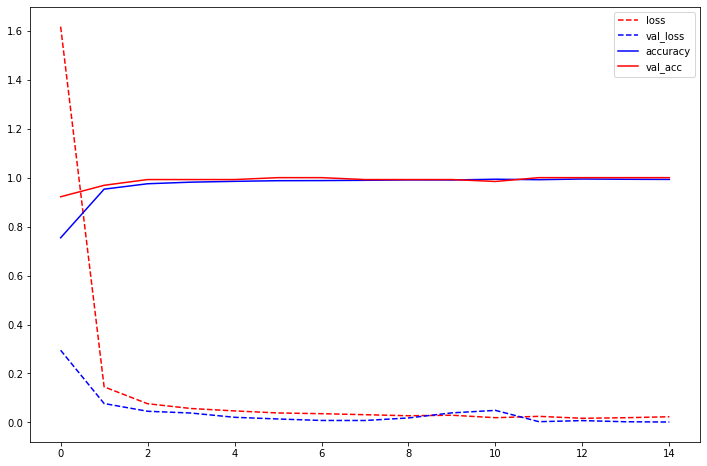

In [108]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.figure(figsize=(12,8))
plt.plot(history_VGG16_adam.history['loss'],'--',c='red')
plt.plot(history_VGG16_adam.history['val_loss'],'--',c='blue')
plt.plot(history_VGG16_adam.history['accuracy'],c='blue')
plt.plot(history_VGG16_adam.history['val_accuracy'],c='red')
plt.legend(['loss','val_loss', 'accuracy','val_acc'])
plt.show()

--------- VGG16_MODEL test data set 을 활용해서 모델 평가하기

(64, 64, 3)
(1, 64, 64, 3)
(VGG16_adam_MODEL) This image most likely belongs to A with a 8.85 percent confidence. .\asl\test\test\A_test.jpg


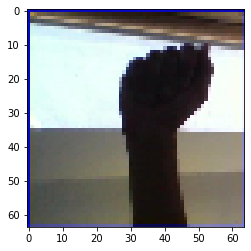

In [96]:
import keras
import glob

tmp = glob.glob('.\\asl\\test\\test\\*.jpg')

img = keras.preprocessing.image.load_img(tmp[0], target_size=(64,64))
plt.imshow(img)

img_array = keras.preprocessing.image.img_to_array(img)
print(np.shape(img_array))

img_array = tf.expand_dims(img_array, 0) # Create a batch
print(np.shape(img_array))

predictions = model_VGG16_adam.predict(img_array)

score = tf.nn.softmax(predictions[0])
score
print(
    "(VGG16_adam_MODEL) This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score)),
    tmp[0]
)

In [97]:
test_all_label=[]; test_all_image=[]
for test_img, test_label in val_ds:
    test_all_label.extend(test_label.numpy())
    test_all_image.extend(test_img.numpy())
np.shape(test_all_label), np.shape(test_all_image)

((17400,), (17400, 64, 64, 3))

In [98]:
model_VGG16_adam.predict(test_all_image[0].reshape(1,64,64,3),test_all_label[0])

array([[0.00000000e+00, 4.47234968e-29, 0.00000000e+00, 1.61835505e-24,
        2.97032705e-31, 2.24153677e-33, 8.65878767e-27, 4.40855379e-31,
        5.32950942e-31, 1.11939880e-25, 3.28102079e-18, 3.84191508e-21,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.18653987e-34,
        3.34297898e-32, 5.16120037e-25, 0.00000000e+00, 0.00000000e+00,
        1.54862356e-15, 2.56037968e-14, 1.00000000e+00, 1.25548192e-31,
        6.13831790e-18, 1.12157014e-25, 1.81722507e-27, 1.37737045e-28,
        4.06978587e-24]], dtype=float32)

In [99]:
from tqdm import tqdm
result=[]
with tf.device('/device:GPU:0'):
    for img in tqdm(test_all_image):
        softmax=model_VGG16_adam.predict(img.reshape(1,64,64,3))
        result.append(np.argmax(softmax))

100%|████████████████████████████████████████████████████████████████████████████| 17400/17400 [12:49<00:00, 22.62it/s]


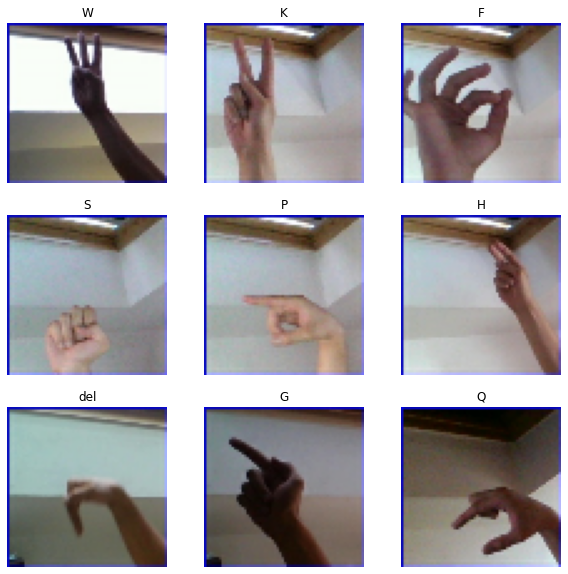

In [16]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(test_all_image[i].astype("uint8"))
  plt.title(class_names[result[i]])
  plt.axis("off")

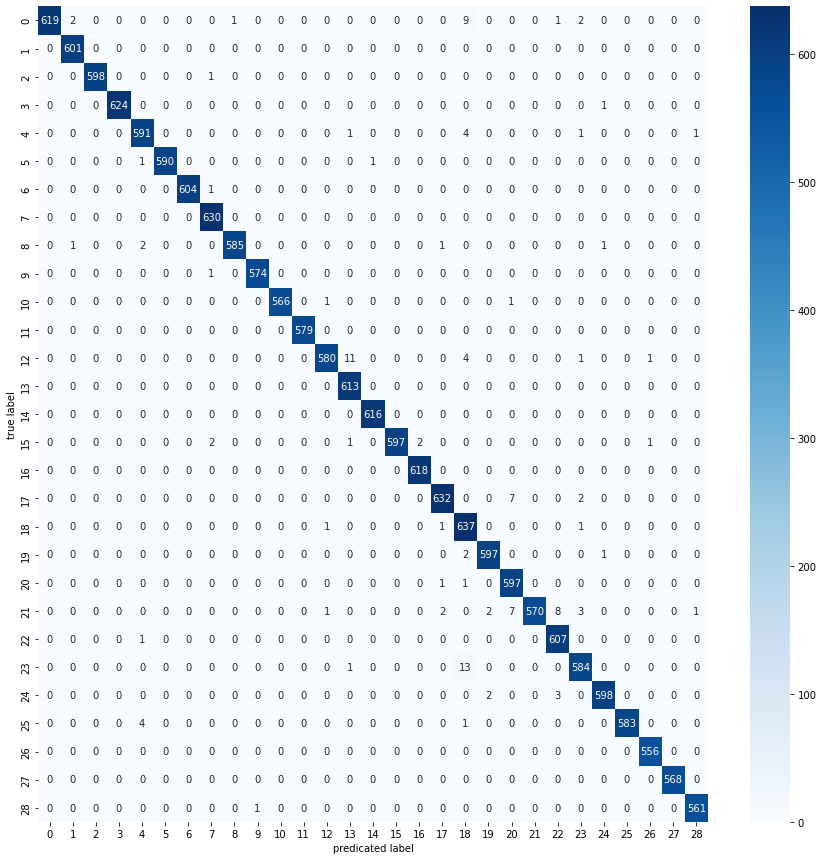

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


#혼돈행렬만들기
plt.figure(figsize=(15,15))
cm=confusion_matrix(test_all_label, result)
sns.heatmap(cm, annot=True, fmt='d',cmap='Blues')
plt.xlabel('predicated label')
plt.ylabel('true label')
plt.show()

------------------model_VGG16_adam 끗.

--------- 논문에서 읽은 학습법 사용해보기

-------- 같은 모델, 다른 optimizer 돌려보기, model_vgg16_SGD 

In [109]:
import pathlib

PATH = "C:\\Users\\HP\\Desktop\\Project\\asl"
file_path = pathlib.Path(PATH)

train_dir = os.path.join(file_path, '.\\train\\train')


BATCH_SIZE = 64
IMG_SIZE = (64, 64)

#train data set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

#valid data set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

class_names = train_ds.class_names
print(class_names)

Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Found 87000 files belonging to 29 classes.
Using 17400 files for validation.
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [3]:
img_shape = (64,64, 3)

# include_top = False인 경우 input_shape = img_size 지정 필요
VGG16_MODEL = tf.keras.applications.VGG16(input_shape = img_shape,
                                         include_top = False,
                                         weights = 'imagenet')

VGG16_MODEL.trainable=False     # VGG16모델 가중치는 변하지 않음.

# flatten이 없음 ( globalaveragepooling으로 대체 ) #  ==> 가중치가 필요없음
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()   

# FFNN의 가중치는 학습됨
prediction_layer = tf.keras.layers.Dense(len(class_names), activation ='softmax')

# model : vgg16이 갖고있는 가중치 + FFNN 가중치로 학습
model_VGG16_SGD = tf.keras.Sequential([
    VGG16_MODEL,
    global_average_layer,
    prediction_layer
])

In [4]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# 학습이 언제 자동 중단 될지를 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

#최적화 모델이 저장될 폴더와 모델의 이름을 정합니다.
modelpath2="./data/model/model_VGG16_SGD_best.hdf5"

# 최적화 모델을 업데이트하고 저장합니다.
checkpointer = ModelCheckpoint(filepath=modelpath2, monitor='val_loss', verbose=0, save_best_only=True)

with tf.device('/device:GPU:0'):
    model_VGG16_SGD.compile(optimizer = 'SGD',
                 loss = 'sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    #모델을 실행합니다
    epochs=15
    history_vgg16_SGD = model_VGG16_SGD.fit(train_ds, epochs=epochs,
                       validation_steps=2,validation_data=(val_ds),
                       verbose=1, callbacks=[early_stopping_callback,checkpointer])

Epoch 1/15
1088/1088 [==============================] - 31s 23ms/step - loss: 2.1594 - accuracy: 0.7752 - val_loss: 0.6692 - val_accuracy: 0.8672
Epoch 2/15
1088/1088 [==============================] - 26s 23ms/step - loss: 0.3906 - accuracy: 0.9160 - val_loss: 0.2092 - val_accuracy: 0.9531
Epoch 3/15
1088/1088 [==============================] - 27s 25ms/step - loss: 0.2458 - accuracy: 0.9423 - val_loss: 0.2281 - val_accuracy: 0.9453
Epoch 4/15
1088/1088 [==============================] - 26s 24ms/step - loss: 0.1870 - accuracy: 0.9536 - val_loss: 0.3897 - val_accuracy: 0.9297
Epoch 5/15
1088/1088 [==============================] - 26s 24ms/step - loss: 0.1305 - accuracy: 0.9646 - val_loss: 0.0335 - val_accuracy: 0.9844
Epoch 6/15
1088/1088 [==============================] - 26s 24ms/step - loss: 0.1115 - accuracy: 0.9703 - val_loss: 0.6168 - val_accuracy: 0.9375
Epoch 7/15
1088/1088 [==============================] - 26s 24ms/step - loss: 0.0871 - accuracy: 0.9753 - val_loss: 0.0046 -

--------- VGG16_MODEL test data set 을 활용해서 모델 평가하기

In [5]:
import keras
import glob

tmp = glob.glob('.\\asl\\test\\test\\*.jpg')

img = keras.preprocessing.image.load_img(tmp[0], target_size=(64,64))
plt.imshow(img)

img_array = keras.preprocessing.image.img_to_array(img)
print(np.shape(img_array))

img_array = tf.expand_dims(img_array, 0) # Create a batch
print(np.shape(img_array))

predictions = model_VGG16_SGD.predict(img_array)

score = tf.nn.softmax(predictions[0])
score
print(
    "(model_VGG16_SGD) This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score)),
    tmp[0]
)



['.\\asl\\test\\test\\A_test.jpg',
 '.\\asl\\test\\test\\B_test.jpg',
 '.\\asl\\test\\test\\C_test.jpg',
 '.\\asl\\test\\test\\D_test.jpg',
 '.\\asl\\test\\test\\E_test.jpg',
 '.\\asl\\test\\test\\F_test.jpg',
 '.\\asl\\test\\test\\G_test.jpg',
 '.\\asl\\test\\test\\H_test.jpg',
 '.\\asl\\test\\test\\I_test.jpg',
 '.\\asl\\test\\test\\J_test.jpg',
 '.\\asl\\test\\test\\K_test.jpg',
 '.\\asl\\test\\test\\L_test.jpg',
 '.\\asl\\test\\test\\M_test.jpg',
 '.\\asl\\test\\test\\nothing_test.jpg',
 '.\\asl\\test\\test\\N_test.jpg',
 '.\\asl\\test\\test\\O_test.jpg',
 '.\\asl\\test\\test\\P_test.jpg',
 '.\\asl\\test\\test\\Q_test.jpg',
 '.\\asl\\test\\test\\R_test.jpg',
 '.\\asl\\test\\test\\space_test.jpg',
 '.\\asl\\test\\test\\S_test.jpg',
 '.\\asl\\test\\test\\T_test.jpg',
 '.\\asl\\test\\test\\U_test.jpg',
 '.\\asl\\test\\test\\V_test.jpg',
 '.\\asl\\test\\test\\W_test.jpg',
 '.\\asl\\test\\test\\X_test.jpg',
 '.\\asl\\test\\test\\Y_test.jpg',
 '.\\asl\\test\\test\\Z_test.jpg']

In [117]:
test_all_label=[]; test_all_image=[]
for test_img, test_label in val_ds:
    test_all_label.extend(test_label.numpy())
    test_all_image.extend(test_img.numpy())
np.shape(test_all_label), np.shape(test_all_image)

((17400,), (17400, 64, 64, 3))

In [118]:
model_VGG16_SGD.predict(test_all_image[0].reshape(1,64,64,3),test_all_label[0])

array([[0.00000000e+00, 0.00000000e+00, 8.13846351e-34, 1.19492154e-17,
        4.41071699e-34, 1.19457178e-30, 7.99633895e-29, 1.32340516e-31,
        1.29969548e-24, 4.66986313e-23, 7.73065007e-22, 1.05481766e-22,
        0.00000000e+00, 0.00000000e+00, 1.07316399e-35, 1.52522751e-27,
        1.17358685e-30, 4.32970568e-23, 1.09818124e-36, 2.74528158e-38,
        4.20372735e-20, 5.85084303e-16, 1.00000000e+00, 8.08930385e-36,
        6.28262820e-21, 1.57560155e-27, 7.71893555e-26, 3.57546380e-35,
        7.34415619e-21]], dtype=float32)

In [120]:
from tqdm import tqdm
result=[]
with tf.device('/device:GPU:0'):
    for img in tqdm(test_all_image):
        softmax=model_VGG16_SGD.predict(img.reshape(1,64,64,3))
        result.append(np.argmax(softmax))

100%|████████████████████████████████████████████████████████████████████████████| 17400/17400 [17:51<00:00, 16.24it/s]


In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(test_all_image[i].astype("uint8"))
  plt.title(class_names[result[i]])
  plt.axis("off")

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


#혼돈행렬만들기
plt.figure(figsize=(15,15))
cm=confusion_matrix(test_all_label, result)
sns.heatmap(cm, annot=True, fmt='d',cmap='Blues')
plt.xlabel('predicated label')
plt.ylabel('true label')
plt.show()

------------------model_VGG16_SGD 끗.

------------------base model = vgg16 생성 완료

------------------basemodel 활용하여, number data classification

In [100]:
import pathlib

PATH = "C:\\Users\\HP\\Desktop\\Project\\num"
file_path = pathlib.Path(PATH)

train_dir = os.path.join(file_path, '.\\train')


BATCH_SIZE = 64
IMG_SIZE = (64, 64)

#train data set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

#valid data set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

class_names = train_ds.class_names
print(class_names)

Found 16500 files belonging to 11 classes.
Using 13200 files for training.
Found 16500 files belonging to 11 classes.
Using 3300 files for validation.
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'unknown']


In [ ]:
from tensorflow.keras.models import load_model
model_num_adam = load_model('.\\data\model\\model_VGG16_adam_best.hdf5')
model_num_SGD = load_model('.\\data\model\\model_VGG16_SGD_best.hdf5')

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# 학습이 언제 자동 중단 될지를 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

#최적화 모델이 저장될 폴더와 모델의 이름을 정합니다.
modelpath="./data/model/model_num_adam.hdf5"

# 최적화 모델을 업데이트하고 저장합니다.
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=0, save_best_only=True)

model_num.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 참고: gpu사용
with tf.device('/device:GPU:0'):

    epochs=15
    history_num = model_num.fit(train_ds, epochs=epochs,
                   validation_steps=2,validation_data=(val_ds),
                   verbose=1, callbacks=[early_stopping_callback,checkpointer])

In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = val_ds.prefetch(buffer_size=AUTOTUNE)

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

prediction_layer = tf.keras.layers.Dense(len(class_names))

inputs = tf.keras.Input(shape=(64, 64, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])



In [18]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
tf.math.truediv_3 (TFOpLambd (None, 64, 64, 3)         0         
_________________________________________________________________
tf.math.subtract_3 (TFOpLamb (None, 64, 64, 3)         0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 2, 2, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1280)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 29)                3714

In [19]:
with tf.device('/device:GPU:0'):
    epochs=15
    history = model.fit(train_ds,
                    epochs=15,
                    validation_data=val_ds)

Epoch 1/15
1088/1088 [==============================] - 19s 15ms/step - loss: 0.8183 - accuracy: 0.7811 - val_loss: 0.3417 - val_accuracy: 0.9232
Epoch 2/15
1088/1088 [==============================] - 16s 15ms/step - loss: 0.3280 - accuracy: 0.9114 - val_loss: 0.2177 - val_accuracy: 0.9503
Epoch 3/15
1088/1088 [==============================] - 17s 15ms/step - loss: 0.2474 - accuracy: 0.9305 - val_loss: 0.1706 - val_accuracy: 0.9594
Epoch 4/15
1088/1088 [==============================] - 17s 15ms/step - loss: 0.2066 - accuracy: 0.9406 - val_loss: 0.1473 - val_accuracy: 0.9628
Epoch 5/15
1088/1088 [==============================] - 19s 17ms/step - loss: 0.1858 - accuracy: 0.9440 - val_loss: 0.1304 - val_accuracy: 0.9664
Epoch 6/15
1088/1088 [==============================] - 18s 16ms/step - loss: 0.1705 - accuracy: 0.9492 - val_loss: 0.1162 - val_accuracy: 0.9697
Epoch 7/15
1088/1088 [==============================] - 18s 16ms/step - loss: 0.1599 - accuracy: 0.9515 - val_loss: 0.1031 -

(model_VGG16_SGD) This image most likely belongs to L with a 7.20 percent confidence. .\sample\sample\sample2\BW\g1 (1).jpg


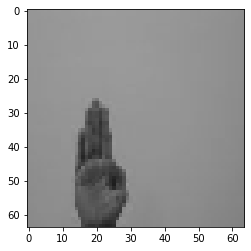

In [53]:
import keras
import glob
import matplotlib.pyplot as plt

# "C:\Users\HP\Desktop\Project\sample\sample\sample2\BW\g1 (1).jpg"

tmp = glob.glob(".\sample\sample\sample2\BW\g1 (1).jpg")

img = keras.preprocessing.image.load_img(tmp[0], target_size=(64,64))
plt.imshow(img)

img_array = keras.preprocessing.image.img_to_array(img)
#print(np.shape(img_array))

img_array = tf.expand_dims(img_array, 0) # Create a batch
#print(np.shape(img_array))

predictions = model_VGG16_SGD.predict(img_array)

score = tf.nn.softmax(predictions[0])
score
# print(
#     "(model_VGG16_SGD) This image most likely belongs to {} with a {:.2f} percent confidence."
#     .format(class_names[np.argmax(score)], 100 * np.max(score)),
#     tmp[0]
# )




In [54]:
model_VGG16_SGD.evaluate(val_ds)

272/272 [==============================] - 8s 27ms/step - loss: 0.0567 - accuracy: 0.9824


[0.05668119713664055, 0.9824137687683105]

(0.08579728, 'L')

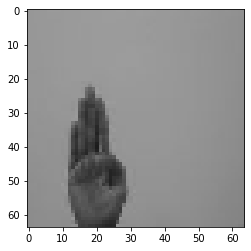

In [77]:
tmp = glob.glob(".\sample\sample\sample2\BW\g1 (6).jpg")

tmp = keras.preprocessing.image.load_img(tmp[0], target_size=(64,64))
plt.imshow(tmp)

img_array = keras.preprocessing.image.img_to_array(tmp)

img_array = tf.expand_dims(img_array, 0) 


predictions = model_VGG16_SGD.predict(img_array)

score = tf.nn.softmax(predictions[0])
score
np.max(score), class_names[np.argmax(score)]

In [88]:
import pathlib

PATH = "C:\\Users\\HP\\Desktop\\Project\\asl\\train"
file_path = pathlib.Path(PATH)

train_dir = os.path.join(file_path, '.\\sample')


BATCH_SIZE = 64
IMG_SIZE = (64, 64)

#train data set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

#valid data set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

class_names = train_ds.class_names
print(class_names)

Found 1800 files belonging to 9 classes.
Using 1440 files for training.
Found 1800 files belonging to 9 classes.
Using 360 files for validation.
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']


In [89]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = val_ds.prefetch(buffer_size=AUTOTUNE)

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

prediction_layer = tf.keras.layers.Dense(len(class_names))

inputs = tf.keras.Input(shape=(64, 64, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [90]:


with tf.device('/device:GPU:0'):
    epochs=30
    history = model.fit(train_ds,
                    
                    epochs=epochs,
                    validation_data=val_ds)

Epoch 1/30
23/23 [==============================] - 3s 47ms/step - loss: 2.6814 - accuracy: 0.1417 - val_loss: 2.1216 - val_accuracy: 0.2361
Epoch 2/30
23/23 [==============================] - 0s 18ms/step - loss: 1.9218 - accuracy: 0.3146 - val_loss: 1.7844 - val_accuracy: 0.3611
Epoch 3/30
23/23 [==============================] - 0s 17ms/step - loss: 1.5469 - accuracy: 0.4507 - val_loss: 1.5251 - val_accuracy: 0.4833
Epoch 4/30
23/23 [==============================] - 0s 18ms/step - loss: 1.2946 - accuracy: 0.5549 - val_loss: 1.3926 - val_accuracy: 0.5139
Epoch 5/30
23/23 [==============================] - 0s 18ms/step - loss: 1.1192 - accuracy: 0.6257 - val_loss: 1.2947 - val_accuracy: 0.5611
Epoch 6/30
23/23 [==============================] - 0s 17ms/step - loss: 1.0090 - accuracy: 0.6785 - val_loss: 1.2168 - val_accuracy: 0.5889
Epoch 7/30
23/23 [==============================] - 0s 18ms/step - loss: 0.9014 - accuracy: 0.7188 - val_loss: 1.1372 - val_accuracy: 0.6278
Epoch 8/30
23

<Figure size 864x288 with 0 Axes>

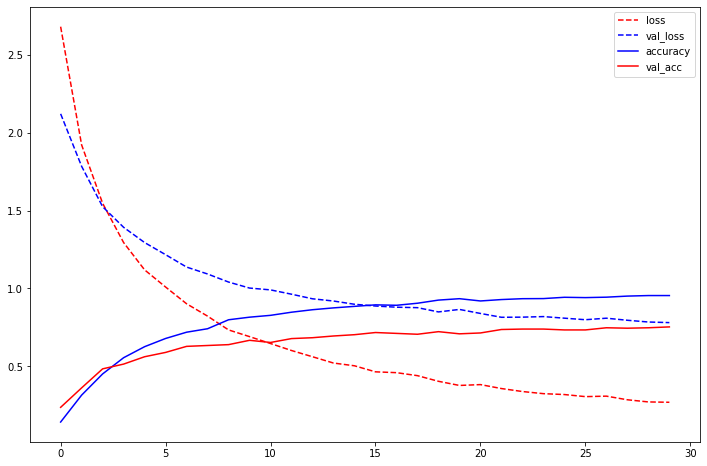

In [91]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.figure(figsize=(12,8))
plt.plot(history.history['loss'],'--',c='red')
plt.plot(history.history['val_loss'],'--',c='blue')
plt.plot(history.history['accuracy'],c='blue')
plt.plot(history.history['val_accuracy'],c='red')
plt.legend(['loss','val_loss', 'accuracy','val_acc'])
plt.show()

(0.5434632, 'f')

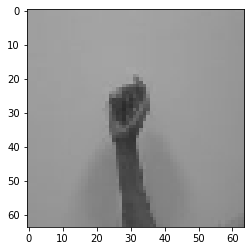

In [96]:
tmp = glob.glob(".\sample\sample\sample2\BW\g7 (4).jpg")

tmp = keras.preprocessing.image.load_img(tmp[0], target_size=(64,64))
plt.imshow(tmp)

img_array = keras.preprocessing.image.img_to_array(tmp)

img_array = tf.expand_dims(img_array, 0) 


predictions = model.predict(img_array)

score = tf.nn.softmax(predictions[0])
score
np.max(score), class_names[np.argmax(score)]

In [97]:
import pathlib

PATH = "C:\\Users\\HP\\Desktop\\Project\\asl\\train"
file_path = pathlib.Path(PATH)

train_dir = os.path.join(file_path, '.\\sample')


BATCH_SIZE = 64
IMG_SIZE = (64, 64)

#train data set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

#valid data set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

class_names = train_ds.class_names
print(class_names)

Found 1800 files belonging to 9 classes.
Using 1440 files for training.
Found 1800 files belonging to 9 classes.
Using 360 files for validation.
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']


In [100]:
img_shape = (64 , 64, 3)

# include_top = False인 경우 input_shape = img_size 지정 필요
VGG16_MODEL = tf.keras.applications.VGG16(input_shape = img_shape,
                                         include_top = False,
                                         weights = 'imagenet')

VGG16_MODEL.trainable=False     # VGG16모델 가중치는 변하지 않음.

# flatten이 없음 ( globalaveragepooling으로 대체 ) #  ==> 가중치가 필요없음
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()   

# FFNN의 가중치는 학습됨
prediction_layer = tf.keras.layers.Dense(len(class_names), activation ='softmax')

# model : vgg16이 갖고있는 가중치 + FFNN 가중치로 학습
model = tf.keras.Sequential([
    VGG16_MODEL,
    global_average_layer,
    prediction_layer
])

# 참고: gpu사용
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# 학습이 언제 자동 중단 될지를 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=20)

#최적화 모델이 저장될 폴더와 모델의 이름을 정합니다.
modelpath="./data/model/Ch14-4-bestmodel.hdf5"

# 최적화 모델을 업데이트하고 저장합니다.
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=0, save_best_only=True)



with tf.device('/device:GPU:0'):
    
    model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy'])
    #모델을 실행합니다
    epochs=40
    history = model.fit(train_ds, epochs=epochs,
                       validation_steps=2,validation_data=(val_ds),
                       verbose=1, callbacks=[early_stopping_callback,checkpointer])
                        


Epoch 1/40
23/23 [==============================] - 2s 32ms/step - loss: 16.8699 - accuracy: 0.1299 - val_loss: 13.7731 - val_accuracy: 0.1719
Epoch 2/40
23/23 [==============================] - 1s 26ms/step - loss: 10.2899 - accuracy: 0.2160 - val_loss: 12.1221 - val_accuracy: 0.1562
Epoch 3/40
23/23 [==============================] - 1s 26ms/step - loss: 7.2215 - accuracy: 0.3000 - val_loss: 7.9787 - val_accuracy: 0.2656
Epoch 4/40
23/23 [==============================] - 1s 26ms/step - loss: 5.3328 - accuracy: 0.3590 - val_loss: 7.2052 - val_accuracy: 0.3203
Epoch 5/40
23/23 [==============================] - 1s 27ms/step - loss: 4.0831 - accuracy: 0.4215 - val_loss: 6.8103 - val_accuracy: 0.3359
Epoch 6/40
23/23 [==============================] - 1s 27ms/step - loss: 3.2369 - accuracy: 0.4958 - val_loss: 4.6619 - val_accuracy: 0.4219
Epoch 7/40
23/23 [==============================] - 1s 26ms/step - loss: 2.5829 - accuracy: 0.5618 - val_loss: 5.3043 - val_accuracy: 0.3828
Epoch 8/4

In [101]:
model.evaluate(val_ds)

6/6 [==============================] - 1s 182ms/step - loss: 1.8191 - accuracy: 0.6667


[1.819123387336731, 0.6666666865348816]

(0.23708956, 'e')

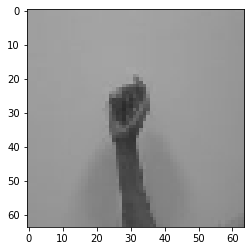

In [102]:
tmp = glob.glob(".\sample\sample\sample2\BW\g7 (4).jpg")

tmp = keras.preprocessing.image.load_img(tmp[0], target_size=(64,64))
plt.imshow(tmp)

img_array = keras.preprocessing.image.img_to_array(tmp)

img_array = tf.expand_dims(img_array, 0) 


predictions = model.predict(img_array)

score = tf.nn.softmax(predictions[0])
score
np.max(score), class_names[np.argmax(score)]